# 3. Sobel and Canny Edge Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Sobel Edge Detection](#sobel)
3. [Canny Edge Detection](#canny)
4. [Double threshold](#double)
5. [Edge Tracking by Hysteresis](#edge)
6. [Ejercicios](#ejercicios)
   
   a.[Modifica el valor de sigma y observa los cambios en las lineas detectas](#a)

   b.[Analiza el comportamiento del Canny Detector con y sin remoción de ruido](#b)

   c.[Experimenta con imágenes con diferentes cantidad de lineas y textura para observar el comportamiento del algoritmo](#c)
7.[Conclusion](#conclusion)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [ ]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter as gauss
from scipy.ndimage.filters import median_filter as med

from google.colab import drive
import os

<ipython-input-1-5c95c253586b>:9: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve
<ipython-input-1-5c95c253586b>:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter as gauss
<ipython-input-1-5c95c253586b>:11: DeprecationWarning: Please import `median_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import median_filter as med


In [ ]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/VISION COMPUTACIONAL'
os.chdir(DATA_PATH)

Mounted at /content/drive


## 2. Sobel Edge Detection <a class="anchor" id="sobel" ></a>

As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values.

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

1. Convert the color image to grayscale for the gradient calculation since it is two dimensional.
2. Compute the gradient in the x and y (horizontal and vertical) directions.
3. Compute the magnitude of the gradient.
4. Normalize the gradient values.

In [ ]:
def edge_sobel(image):
    from scipy import ndimage
    import skimage.color as sc
    import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

In [ ]:
# Cargar la imagen (reemplaza 'tu_imagen.jpg' con la ruta de tu imagen)
img = cv2.imread('data/piramides.jpg')

# Convertir la imagen a un array de NumPy
img_array = np.array(img)

# Guardar el array como un archivo .npy
np.save('data/img.npy', img_array)

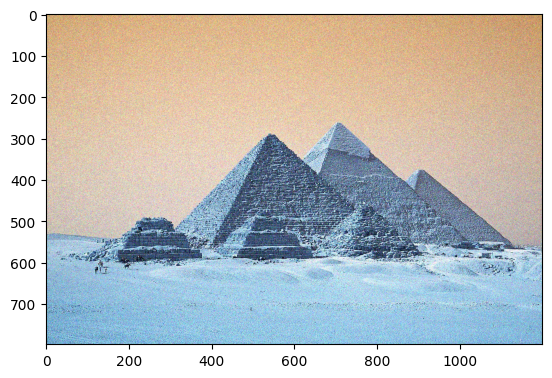

In [ ]:
original_image = np.load('data/img.npy')

img = skimage.util.random_noise(original_image)
plt.imshow(img)

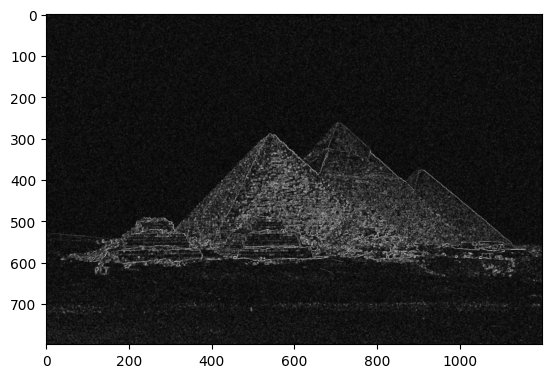

In [ ]:
img_med = med(img, size=2)
img_edge = edge_sobel(img_med)
plt.imshow(img_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

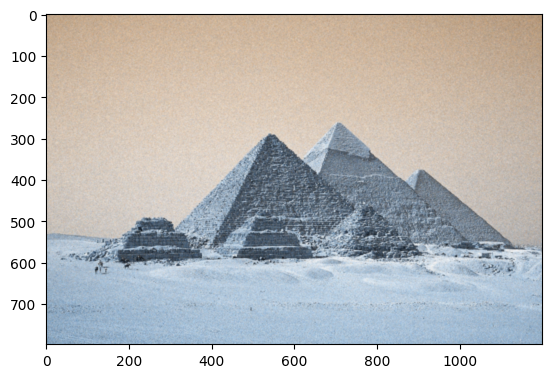

In [ ]:
img_gauss = gauss(img, sigma=1)
plt.imshow(img_gauss)

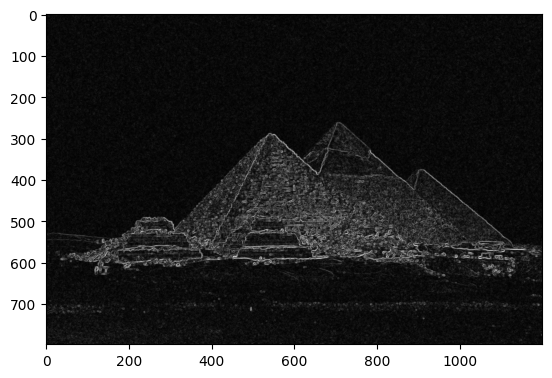

In [ ]:
img_edge = edge_sobel(img_gauss)
plt.imshow(img_edge, cmap="gray")

## 3. Canny Edge Detection <a class="anchor" id="canny" ></a>

Steps:
1. Noise Reduction
2. Gradient Calculation
3. Non-maximum Supression
4. Double Threshold
5. Edge Tracking by Hysteresis

**Pre-requisite:** Convert the image to grayscale before algorithm.

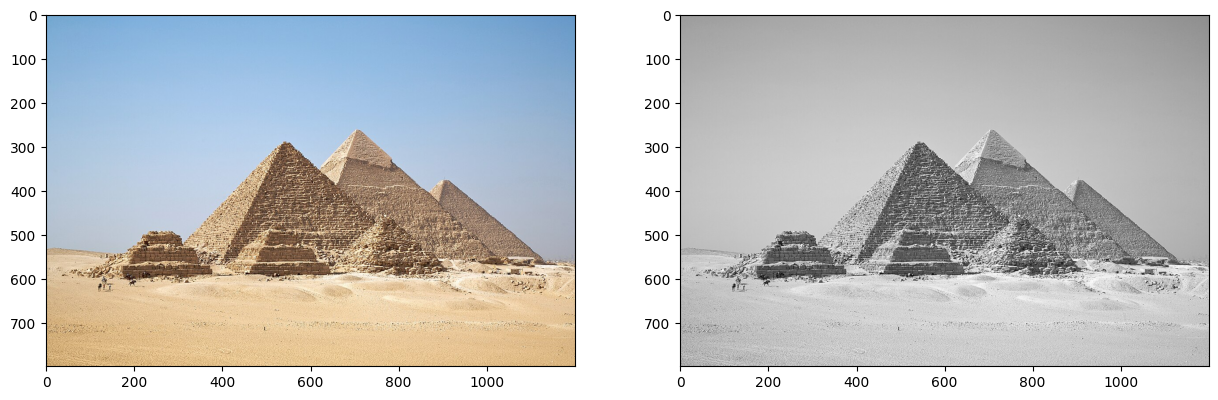

In [ ]:
img = cv2.imread('data/piramides.jpg')

img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### 1.1 Sigma Parameter $\sigma$

In [ ]:
# Change this parameter
sigma = 10 # 1, 3, 5, 10, 20, ...

### 1.2 Kernel Size Parameter

In [ ]:
kernel_size = 3

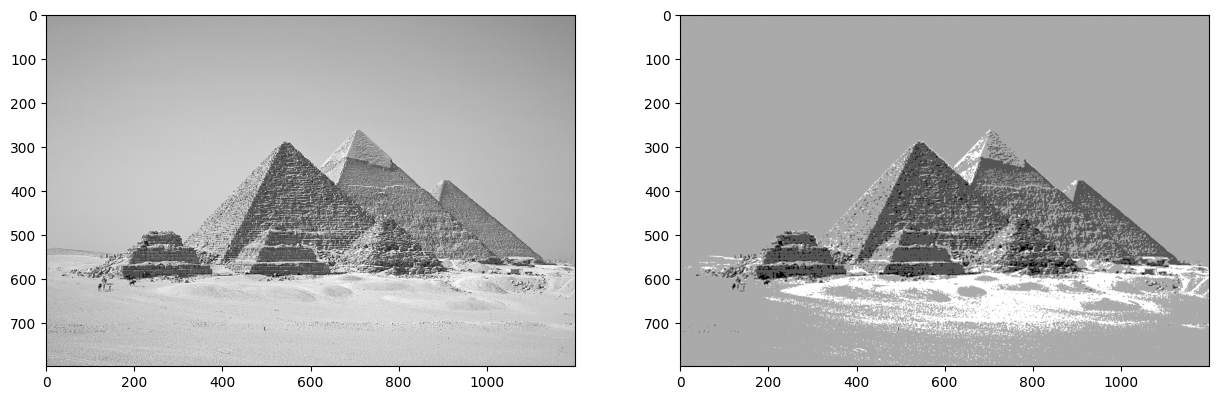

In [ ]:
img_gaussian = convolve(img_gray, gaussian_kernel(kernel_size, sigma))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_gaussian, cmap="gray")

### 2. Gradient Calculation

Edges correspond to a change of pixels intensity.

To detect it, the easiest way is to apply filters that highlight this intensity change in both directions:
- horizontal $(x)$
- and vertical $(y)$

It can be implemented by convoling $I$ with *Sobel kernels* $Kx$ and $Ky$

$$
K_x = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}, K_y = \begin{bmatrix}
1 & 2& 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

$$
|G| = \sqrt{I_x^2 + I_y^2},
\theta(x, y) = arctan(\frac{I_y}{I_x})
$$

In [ ]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

<ipython-input-14-dddc2aedcd55>:5: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Ix = ndimage.filters.convolve(img, Kx)
<ipython-input-14-dddc2aedcd55>:6: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Iy = ndimage.filters.convolve(img, Ky)


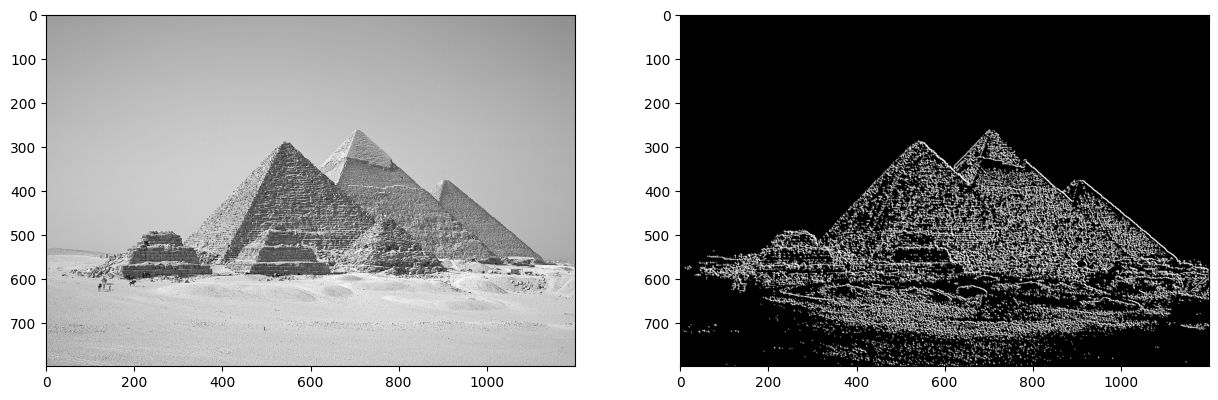

In [ ]:
G, theta = sobel_filters(img_gaussian)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(G, cmap="gray")

### 3. Non-Maximum supression

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm.

In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

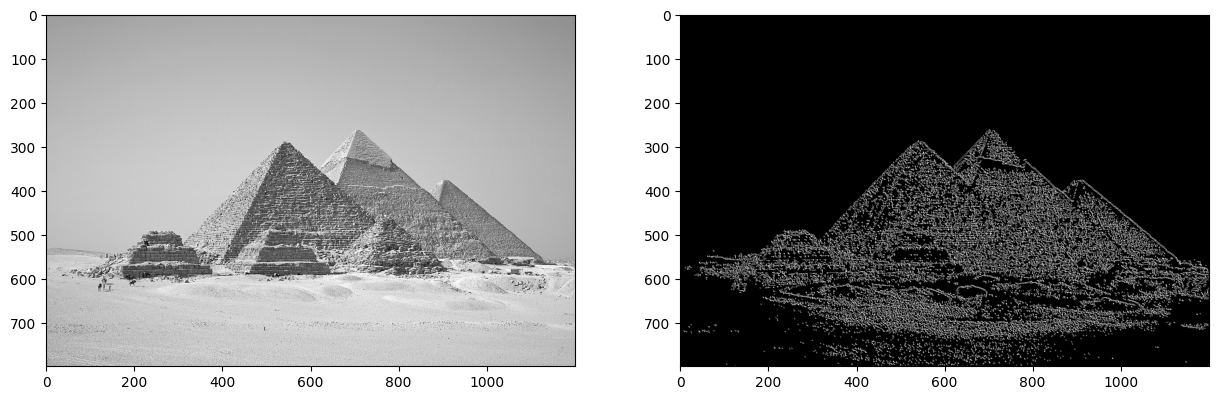

In [ ]:
img_nonmax = non_max_suppression(G, theta)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_nonmax, cmap="gray")

### 4. Double threshold <a class="anchor" id="double" ></a>

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

In [ ]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

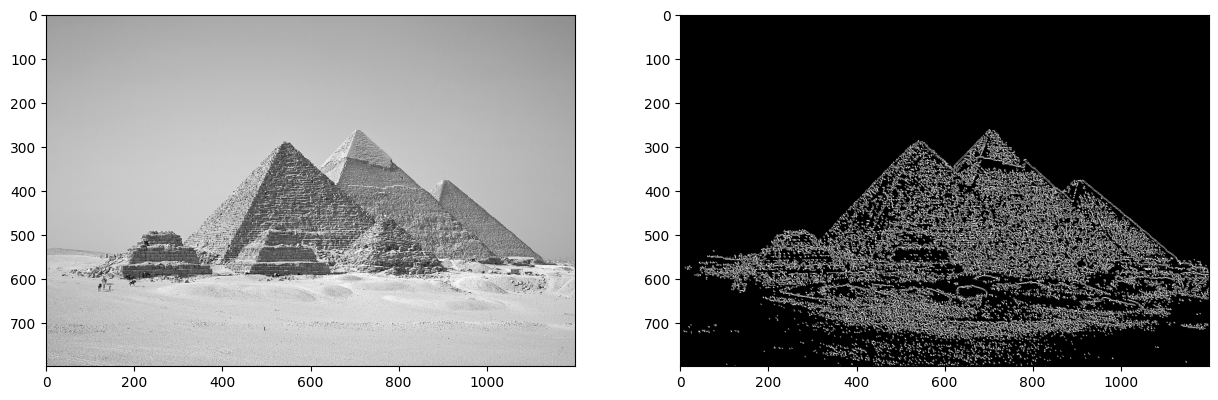

In [ ]:
img_threshold = threshold(img_nonmax)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_threshold, cmap="gray")

### 5. Edge Tracking by Hysteresis <a class="anchor" id="edge" ></a>

The hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [ ]:
def hysteresis(img, weak = 75, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

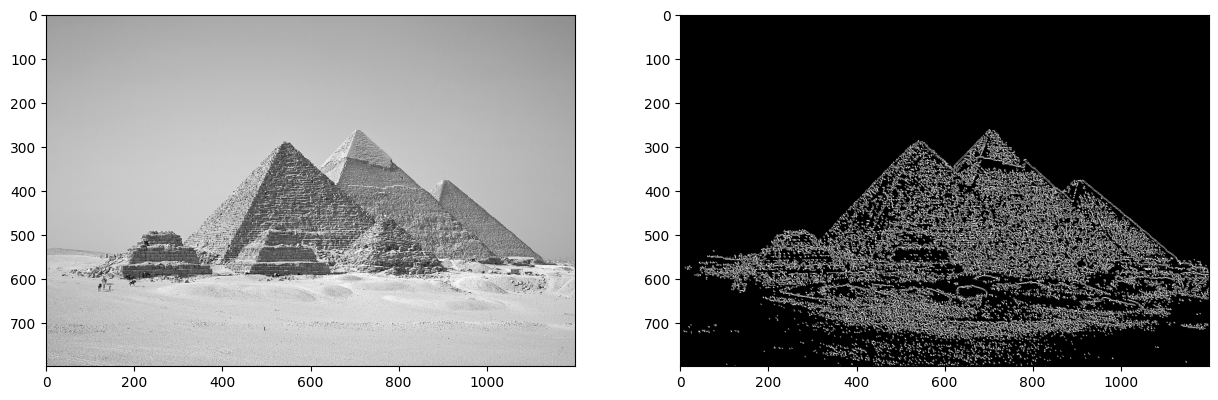

In [ ]:
img_final = hysteresis(img_threshold)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_final, cmap="gray")

In [ ]:
# TODO: Challenge

# 6. Ejercicios <a class="anchor" id="ejercicios" ></a>

#### **a) modifica el valor de sigma y observa los cambios en las lineas detectas** <a class="anchor" id="a" ></a>

En este reto, hemos elegido una imagen del Centro Heydar Aliyev, diseñado por la reconocida arquitecta Zaha Hadid, como ejemplo para experimentar con el Detector de Bordes de Canny. Este edificio icónico de Bakú, Azerbaiyán, es conocido por su arquitectura moderna y fluida, destacándose principalmente por sus curvas y líneas orgánicas, lo que lo convierte en un caso ideal para probar el Canny.

Al utilizar esta imagen del Centro Heydar Aliyev, podemos experimentar y visualizar cómo el Detector de Canny responde a diferentes tipos de bordes:

* Con sigma bajo (menos suavizado): Es probable que el algoritmo detecte más bordes finos, pero también puede capturar más ruido y detalles irrelevantes.
* Con sigma alto (más suavizado): Esto debería reducir la detección de bordes más pequeños y ruidosos, pero podría perder detalles sutiles de las curvas del edificio.

Este análisis no solo nos permite explorar cómo el Detector de Canny identifica bordes, sino también cómo los ajustes de sigma influyen en la calidad y cantidad de los bordes detectados en una estructura arquitectónica compleja como la de Zaha Hadid.

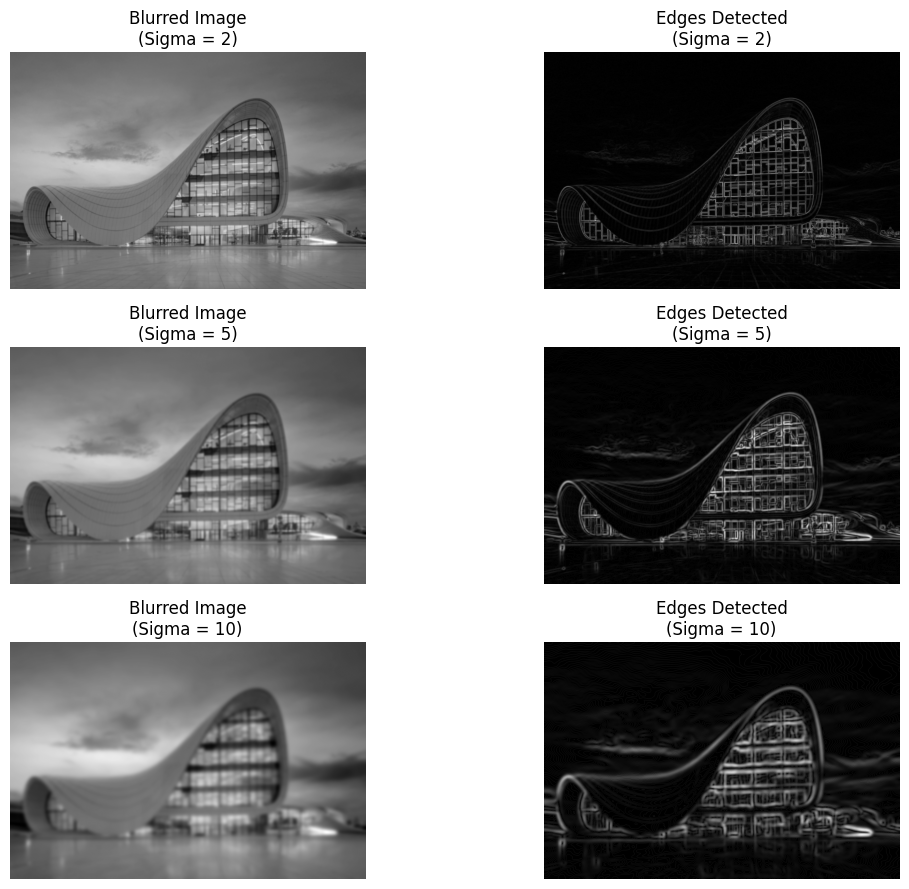

In [ ]:
# Función para aplicar el filtro Gaussiano
def gauss(image, sigma):
    return cv2.GaussianBlur(image, (0, 0), sigma)

# Función para detectar bordes usando Sobel
def edge_sobel(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = cv2.magnitude(grad_x, grad_y)
    return np.uint8(np.absolute(grad_mag))

# Cargar la imagen en escala de grises
img = cv2.imread('data/zaha.jpg', 0)

# Verificar si la imagen se cargó correctamente
if img is None:
    raise FileNotFoundError("La imagen no se pudo cargar. Verifique la ruta del archivo.")

# Valores de sigma para aplicar el filtro Gaussiano
sigma_values = [2, 5, 10]

# Crear la figura para visualizar los resultados
fig, axes = plt.subplots(len(sigma_values), 2, figsize=(12, 9))

# Iterar sobre cada valor de sigma y aplicar los filtros
for i, sigma in enumerate(sigma_values):
    img_gauss = gauss(img, sigma)  # Aplicar filtro Gaussiano
    img_edge = edge_sobel(img_gauss)  # Detectar bordes con Sobel

    # Mostrar imágenes
    axes[i, 0].imshow(img_gauss, cmap="gray")
    axes[i, 0].set_title(f"Blurred Image\n(Sigma = {sigma})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(img_edge, cmap="gray")
    axes[i, 1].set_title(f"Edges Detected\n(Sigma = {sigma})")
    axes[i, 1].axis("off")

# Ajustar el diseño de la figura para evitar solapamientos
plt.tight_layout()
plt.show()


Se puede notar que a medida que el valor de sigma aumenta, el efecto de suavizado en la imagen se vuelve más evidente. Como consecuencia, los bordes detectados con el operador Sobel pierden definición y claridad. Con valores bajos de sigma, los contornos se mantienen con mayor precisión, mientras que con valores altos, los bordes tienden a difuminarse o incluso desaparecer en algunas áreas debido a la disminución de los detalles de alta frecuencia en la imagen.

#### **b) Analiza el comportamiento del Canny Detector con y sin remoción de ruido** <a class="anchor" id="b" ></a>

El Detector de Bordes de Canny es ideal para analizar imágenes de estructuras arquitectónicas como el Edificio El Tornillo de Panamá, ya que este tipo de imagen presenta características claras que son bien detectadas por el algoritmo de Canny, tales como bordes definidos, líneas rectas, curvas y detalles geométricos.

Razón por el cual eligmos la imagen del Edificio El Tornillo:

* Estructura Geométrica Compleja: El Edificio El Tornillo tiene una forma moderna y distintiva, con líneas rectas y curvas, lo que lo convierte en un candidato ideal para el análisis con el detector de Canny.

* Contraste de bordes: Este tipo de arquitectura tiene una gran cantidad de bordes bien definidos que el detector puede identificar fácilmente, proporcionando resultados claros en las áreas de mayor contraste.

* Superficies planas y detalles: El Canny es bueno para detectar bordes de superficies lisas y detalles arquitectónicos de la estructura, como ventanas, puertas, líneas de contorno, y otros detalles pequeños.

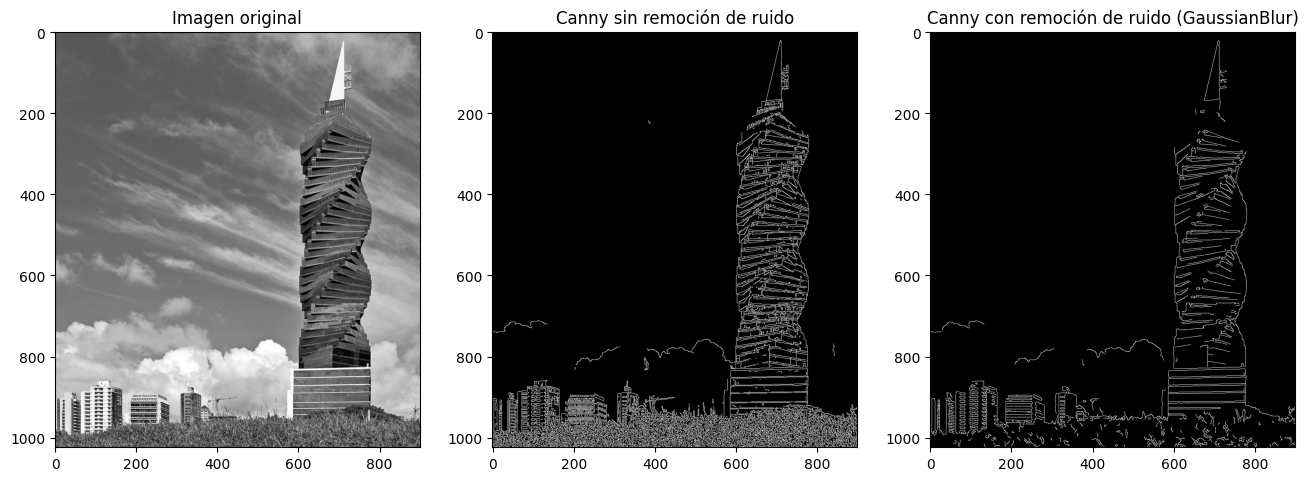

In [ ]:
# Cargar la imagen en escala de grises
img = cv2.imread('data/tower.jpg', 0)  # Reemplaza 'tu_imagen.jpg' con el nombre de tu imagen

# Aplicar Canny sin remoción de ruido
edges_no_filter = cv2.Canny(img, 100, 200)

# Aplicar un filtro GaussianBlur para la remoción de ruido
blurred = cv2.GaussianBlur(img, (5, 5), 1.5)

# Aplicar Canny después de la remoción de ruido
edges_with_filter = cv2.Canny(blurred, 100, 200)

# Mostrar los resultados
plt.figure(figsize=(16, 8))

#original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original')

# Sin filtro de ruido
plt.subplot(1, 3, 2)
plt.imshow(edges_no_filter, cmap='gray')
plt.title('Canny sin remoción de ruido')

# Con filtro de ruido
plt.subplot(1, 3, 3)
plt.imshow(edges_with_filter, cmap='gray')
plt.title('Canny con remoción de ruido (GaussianBlur)')

plt.show()


#### **c) Experimenta con imágenes con diferentes cantidad de lineas y textura para observar el comportamiento del algoritmo** <a class="anchor" id="c" ></a>

El uso de imágenes específicas como el Puente Centenario, los vitrales y un balón tiene un propósito claro al experimentar con el Detector de Bordes de Canny.

🟢 Balón (Imagen con formas simples y redondeadas):

Un balón presenta una forma simple y geométrica, como un círculo, que puede ser fácilmente detectada por el algoritmo de Canny. Es un buen ejemplo para estudiar cómo el detector identifica bordes en imágenes con formas simples y bien definidas, como los bordes de un objeto redondeado. A pesar de su simplicidad, el detector de Canny puede mostrar la diferencia en su capacidad de detectar bordes claros y nítidos.

🟢 Puente Centenario (Imagen con muchas líneas):

El Puente Centenario es una estructura arquitectónica con líneas y bordes bien definidos, como cables, pilares y caminos. Estas características hacen que sea ideal para el detector de bordes de Canny, ya que permite ver cómo el algoritmo detecta las líneas rectas y los bordes fuertes presentes en la estructura. Este tipo de imagen es especialmente útil para ver cómo Canny responde a formas geométricas claras y estructuras definidas.

🟢Vitrales (Imagen con textura compleja):

Los vitrales suelen tener patrones intrincados con bordes complejos, colores y detalles finos. Estos patrones crean un desafío para el detector de bordes de Canny, ya que el algoritmo podría generar muchos bordes falsos debido a las pequeñas variaciones en la textura. Utilizar vitrales permite observar cómo el detector maneja texturas complejas y cómo los bordes pequeños o sutiles pueden afectar el resultado.


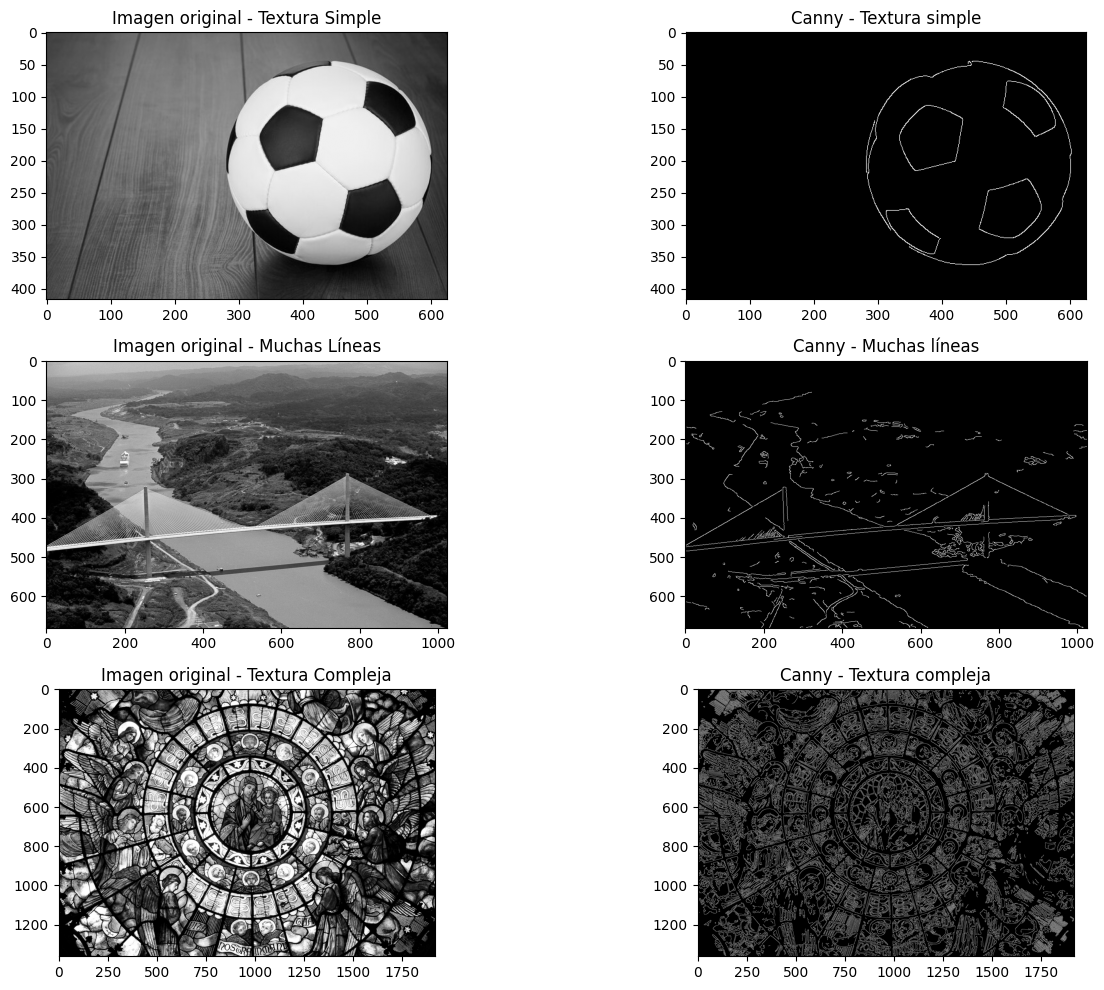

In [ ]:
# Cargar diferentes imágenes
img_simple_texture = cv2.imread('data/balon.jpg', 0)  # Imagen con textura simple
img_muchas_lineas = cv2.imread('data/centenario.jpg', 0)  # Imagen con muchas líneas
img_textura_compleja = cv2.imread('data/vitrales.jpg', 0)  # Imagen con textura compleja

# Función para aplicar Canny y mostrar los resultados
def mostrar_canny(img, titulo):
    # Aplicar un filtro de suavizado para remoción de ruido
    blurred = cv2.GaussianBlur(img, (5, 5), 1.5)

    # Aplicar el detector de bordes de Canny
    edges = cv2.Canny(blurred, 100, 200)

    # Mostrar los resultados
    plt.imshow(edges, cmap='gray')
    plt.title(titulo)

# Crear una figura para mostrar los resultados
plt.figure(figsize=(14, 10))

# Imágenes de experimentación con diferentes características

# Imagen simple (textura simple)
plt.subplot(3, 2, 1)
plt.imshow(img_simple_texture, cmap='gray')
plt.title('Imagen original - Textura Simple')

plt.subplot(3, 2, 2)
mostrar_canny(img_simple_texture, 'Canny - Textura simple')

# Imagen con muchas líneas
plt.subplot(3, 2, 3)
plt.imshow(img_muchas_lineas, cmap='gray')
plt.title('Imagen original - Muchas Líneas')

plt.subplot(3, 2, 4)
mostrar_canny(img_muchas_lineas, 'Canny - Muchas líneas')

# Imagen con textura compleja
plt.subplot(3, 2, 5)
plt.imshow(img_textura_compleja, cmap='gray')
plt.title('Imagen original - Textura Compleja')

plt.subplot(3, 2, 6)
mostrar_canny(img_textura_compleja, 'Canny - Textura compleja')

# Mostrar las imágenes
plt.tight_layout()
plt.show()



# 7. Conclusión <a class="anchor" id="conclusion" ></a>




A lo largo de este experimento, hemos utilizado diversas imágenes para explorar cómo el Detector de Bordes de Canny funciona en diferentes tipos de estructuras y texturas, como el Centro Heydar Aliyev de Zaha Hadid, el Edificio El Tornillo de Panamá y otras imágenes con variaciones en líneas y texturas.

El Detector de Bordes de Canny demostró ser una herramienta muy eficaz para identificar bordes geométricos claros en imágenes con líneas rectas y estructuras bien definidas. Sin embargo, en imágenes con texturas complejas o curvas suaves, el algoritmo tiende a generar más bordes falsos o a perder detalles sutiles si no se ajustan adecuadamente los parámetros, como el valor de sigma o los umbrales de Canny.

Los hallazgos más relevantes son:

* El valor de sigma: Afecta la cantidad de suavizado y, por lo tanto, la precisión de los bordes detectados.
* Los umbrales de Canny: Es fundamental ajustar los umbrales para evitar bordes falsos o la pérdida de información en imágenes con mucho detalle.
* Imágenes con detalles complejos: Requieren un suavizado mayor y ajustes más finos en los parámetros para obtener una detección de bordes precisa.

Este análisis sugiere que el uso de Canny es particularmente útil para imágenes arquitectónicas y de estructuras geométricas, pero puede necesitar ajustes finos dependiendo de las características visuales de la imagen.